<a href="https://colab.research.google.com/github/yash7210/MEC-project/blob/main/ActivityRecognitionLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import datetime
import glob
import requests
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

%matplotlib inline

# Download and extract data

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip'
file_name = url.split('/')[-1]

if not os.path.exists(file_name):
    with requests.get(url, stream=True) as response, open(file_name, 'wb') as file:
        print(f'Downloading {file_name}...')
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    with zipfile.ZipFile(file_name) as zip_file:
        print(f'Extracting {file_name}...')
        zip_file.extractall()

Extracting wisdm-dataset.zip...


# Read data to memory and write to csv

In [ ]:
DATA_DIR = 'data'
DATA_PATH = 'data/har.csv'
RAW_DATA_DIR = 'wisdm-dataset/raw/watch'

ACTIVITY_MAP = {
    'K' : 'drinking',
    'L' : 'eating sandwich'
}

def read_watch_data():
    if os.path.exists(DATA_PATH):
        return pd.read_csv(DATA_PATH)
    sensor_dfs = []
    columns = ['subject', 'activity', 'timestamp']
    for sensor in ['accel', 'gyro']:
        files = sorted(glob.glob(os.path.join(os.path.join(RAW_DATA_DIR, sensor), '*.txt')))
        df = pd.concat([pd.read_csv(file, header=None) for file in files], axis=0, ignore_index=True)
        df.columns = columns + [sensor + '_' + axis for axis in 'xyz']
        df[sensor + '_z'] = df[sensor + '_z'].str.replace(';', '', regex=False).astype(float)
        df = df.loc[df['activity'].isin(ACTIVITY_MAP.keys())]
        df['activity'] = df['activity'].map(ACTIVITY_MAP)
        sensor_dfs.append(df)
    har_df = pd.merge(sensor_dfs[0], sensor_dfs[1], on=columns)
    har_df = har_df.dropna()
    har_df = har_df.drop_duplicates()
    os.makedirs(DATA_DIR, exist_ok=True)
    har_df.to_csv(DATA_PATH, index=False)
    return har_df

In [ ]:
har_df = read_watch_data()

In [ ]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359142 entries, 0 to 380759
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   subject    359142 non-null  int64  
 1   activity   359142 non-null  object 
 2   timestamp  359142 non-null  int64  
 3   accel_x    359142 non-null  float64
 4   accel_y    359142 non-null  float64
 5   accel_z    359142 non-null  float64
 6   gyro_x     359142 non-null  float64
 7   gyro_y     359142 non-null  float64
 8   gyro_z     359142 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 27.4+ MB


In [ ]:
FEATURES = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

stats_df = har_df[FEATURES].describe().loc[['count','mean','std','min','max']].round(3)
stats_df.style.applymap(color_negative_red)

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,359142.000000,359142.000000,359142.000000,359142.000000,359142.000000,359142.000000
mean,-2.972000,-4.661000,3.418000,-0.000000,-0.003000,-0.001000
std,4.810000,4.342000,3.509000,0.630000,0.312000,0.487000
min,-19.771000,-19.827000,-13.334000,-16.122000,-5.059000,-7.346000
max,19.645000,20.040000,19.623000,20.453000,5.858000,11.968000


### Clip values to -30 and 30

In [ ]:
har_df[FEATURES] = har_df[FEATURES].clip(-30, 30)

In [ ]:
har_df[FEATURES].describe().loc[['count','mean','std','min','max']].round(3)

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,359142.000,359142.000,359142.000,359142.000,359142.000,359142.000
mean,-2.972,-4.661,3.418,-0.000,-0.003,-0.001
std,4.810,4.342,3.509,0.630,0.312,0.487
min,-19.771,-19.827,-13.334,-16.122,-5.059,-7.346
max,19.645,20.040,19.623,20.453,5.858,11.968


# Exploratory Data Analysis

In [ ]:
with pd.option_context('display.max_rows', None):
    display(pd.pivot_table(har_df, index=har_df.columns[:2].tolist(), aggfunc='count'))

accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  \
subject activity                                                             
1600    drinking            3604     3604     3604    3604    3604    3604   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1601    drinking            3601     3601     3601    3601    3601    3601   
        eating sandwich     3601     3601     3601    3601    3601    3601   
1602    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1603    drinking            3602     3602     3602    3602    3602    3602   
        eating sandwich     3602     3602     3602    3602    3602    3602   
1604    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1605    drinking            3601     3601     3601    3601    3601    3601   
        eating sandwich     3602     3602     3602    3602    3602    3602   
1606    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1607    drinking            3602     3602     3602    3602    3602    3602   
        eating sandwich     4577     4577     4577    4577    4577    4577   
1608    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1609    drinking            6070     6070     6070    6070    6070    6070   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1610    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1611    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1612    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3984     3984     3984    3984    3984    3984   
1613    drinking            3602     3602     3602    3602    3602    3602   
        eating sandwich     3602     3602     3602    3602    3602    3602   
1614    drinking            3601     3601     3601    3601    3601    3601   
        eating sandwich     3601     3601     3601    3601    3601    3601   
1615    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1616    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1617    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1618    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1619    drinking            3601     3601     3601    3601    3601    3601   
        eating sandwich     3600     3600     3600    3600    3600    3600   
1620    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1621    drinking            3600     3600     3600    3600    3600    3600   
        eating sandwich     3600     3600     3600    3600    3600    3600   
1622    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1623    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3603    3603    3603    3603   
1624    drinking            3603     3603     3603    3603    3603    3603   
        eating sandwich     3603     3603     3

### Readings for subjects 1637, 1638, 1639, and 1640 look out of 'shape'. Numerous data points most likely got dropped because of varying timestamps while merging rendering them unreliable. Let's plot to confirm.

In [ ]:
def plot_sensor_readings(sensor, subject, start=0, end=1024):
    for activity in ACTIVITY_MAP.values():
        data = har_df.query(f'subject == {subject} and activity == "{activity}"')[start:end]
        if len(data) == 0:
            continue
        fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)
        plot_axis(ax0, data['timestamp'], data[sensor + '_x'], 'X-Axis')
        plot_axis(ax1, data['timestamp'], data[sensor + '_y'], 'Y-Axis')
        plot_axis(ax2, data['timestamp'], data[sensor + '_z'], 'Z-Axis')
        plt.subplots_adjust(hspace=0.2)
        fig.suptitle(sensor.upper() + ' :: ' + activity.upper())
        plt.subplots_adjust(top=0.90)
        plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

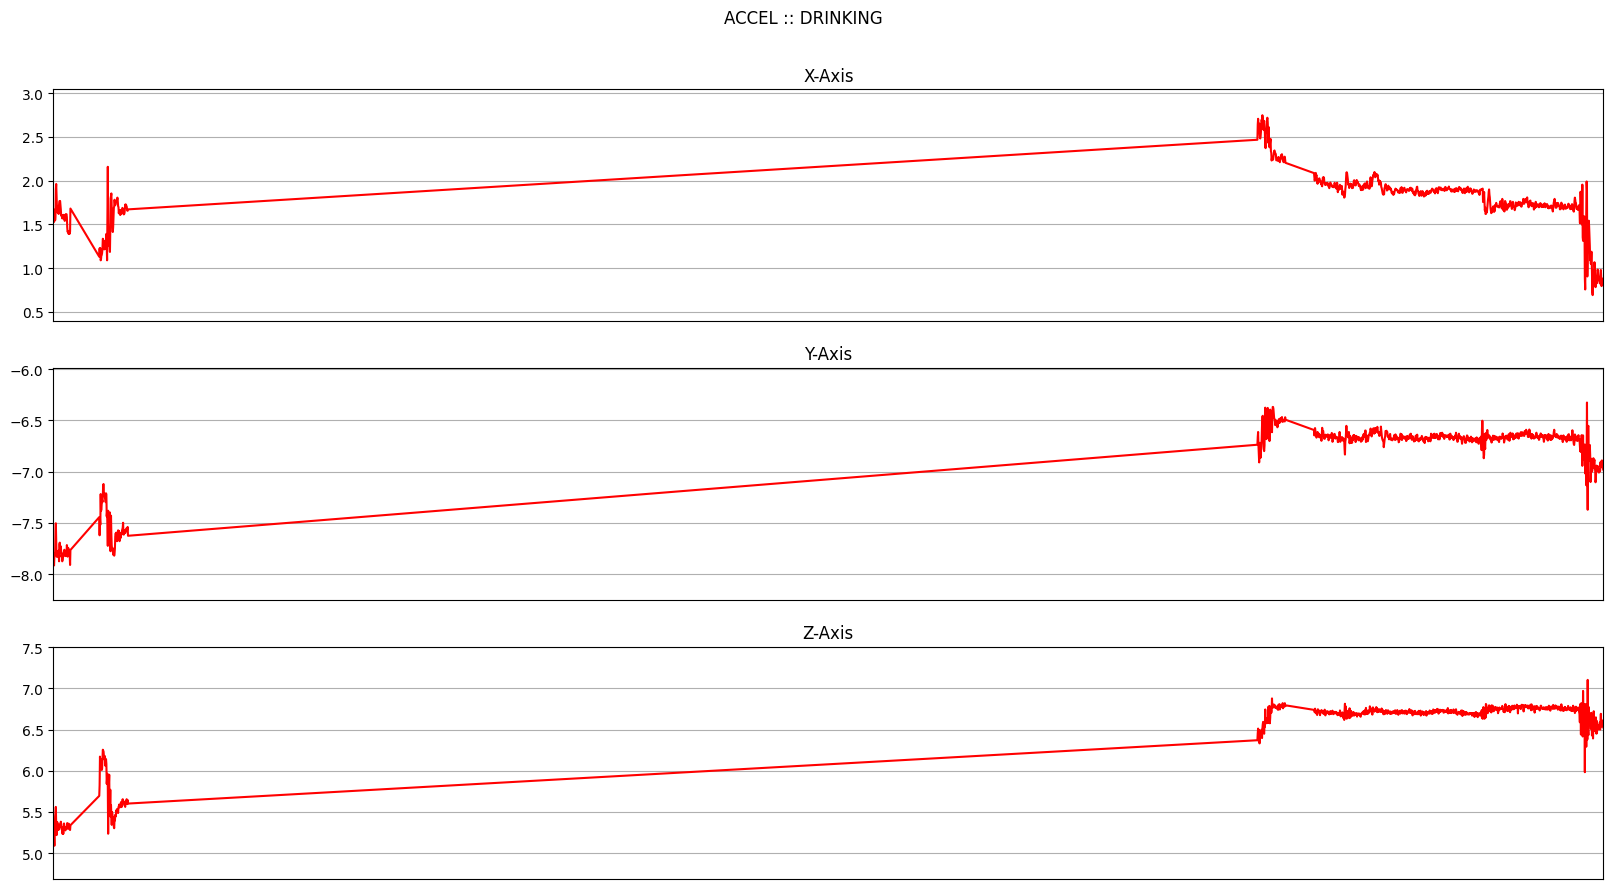

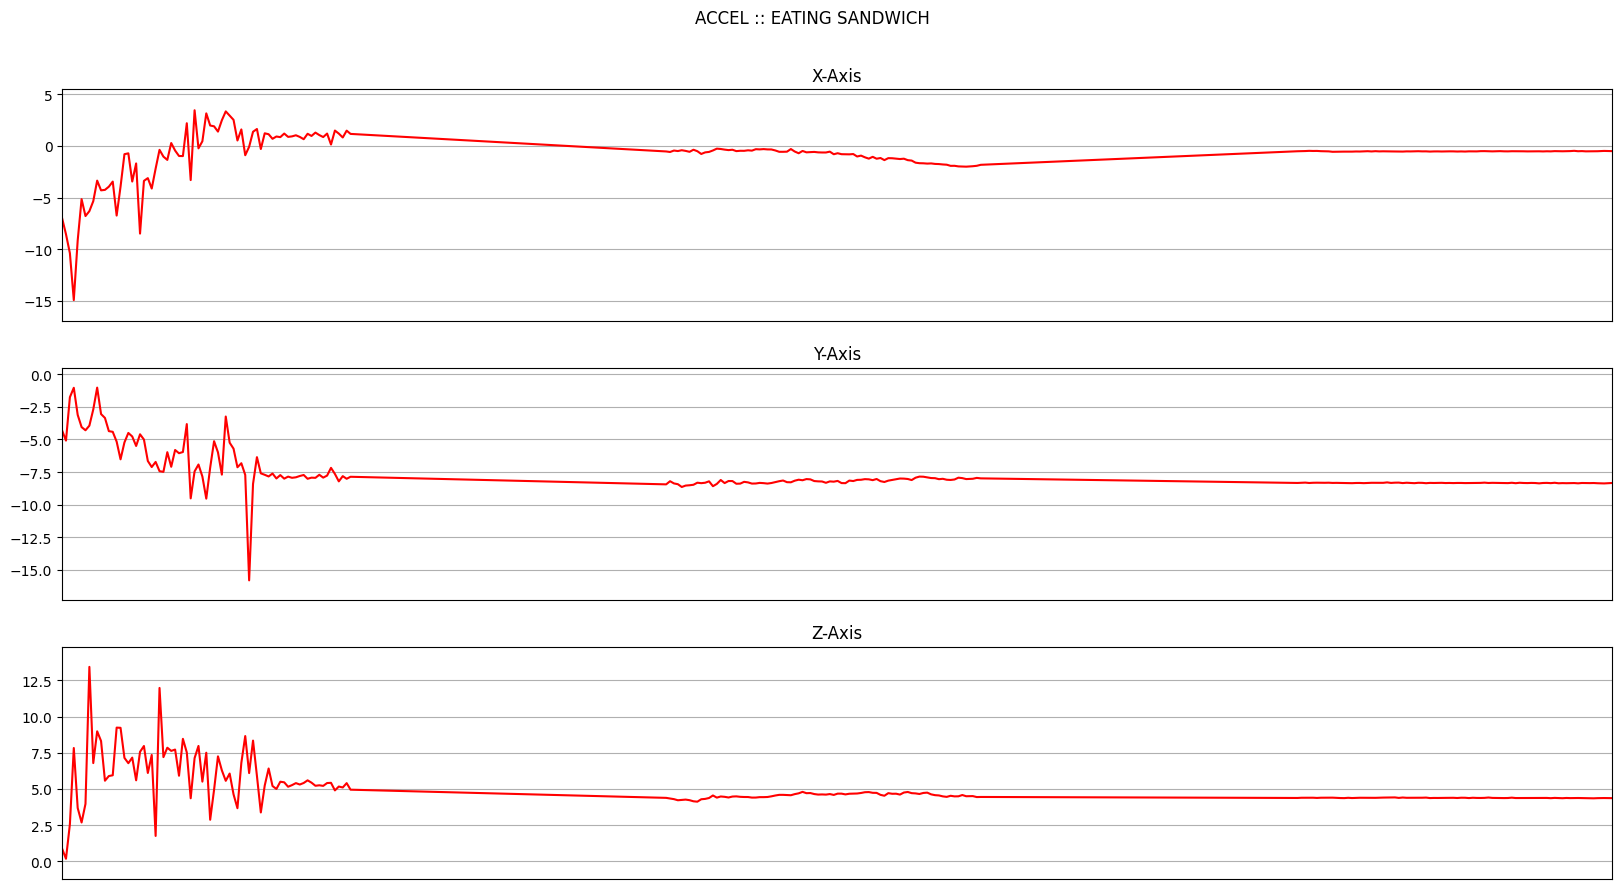

In [ ]:
plot_sensor_readings('accel', 1638)

### Drop data for subjects 1637 to 1640 inclusive.

In [ ]:
har_df = har_df.loc[~har_df['subject'].isin([1637, 1638, 1639, 1640])].reset_index()

Text(0, 0.5, 'Count')

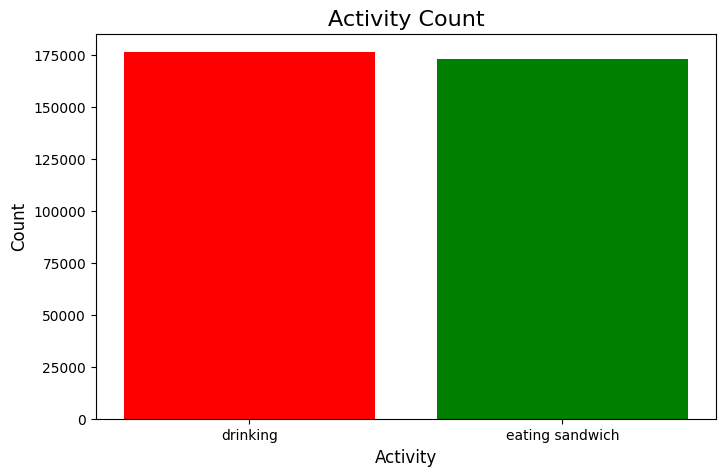

In [ ]:
activity_count = har_df.activity.value_counts()

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(activity_count.index, activity_count.values, color=['r', 'g', 'b', 'y', 'k'])
ax.set_title('Activity Count', {'fontsize': 16})
ax.set_xlabel('Activity', {'fontsize': 12})
ax.set_ylabel('Count', {'fontsize': 12})

# Train and evaluate

In [ ]:
SEQ_LEN = 60 # corresponding to 3 secs (20 * 3). Data was sampled at 20 Hz.
COLUMNS = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
DIMS = len(COLUMNS)

In [ ]:
scaler = MinMaxScaler()
har_df[COLUMNS] = scaler.fit_transform(har_df[COLUMNS])

encoder = LabelEncoder()
har_df['activity'] = encoder.fit_transform(har_df['activity'])

In [ ]:
X = []
y = []

for index, data in har_df.groupby(['subject', 'activity'], sort=False):
    data = data[COLUMNS].values
    label = index[1]
    for i in range(0, len(data) - SEQ_LEN, SEQ_LEN):
        X.append(np.expand_dims(data[i:i+SEQ_LEN], axis=0))
        y.append(label)

X = np.concatenate(X)
y = np.asarray(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=43)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, input_shape=(SEQ_LEN, DIMS)),
    tf.keras.layers.LSTM(units=32),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 32)            608       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 11170 (43.63 KB)
Trainable params: 11170 (43.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
                        tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 if epoch < 10 else 0.001 * tf.math.exp(0.1 * (10 - epoch))),
                        tf.keras.callbacks.TensorBoard()
                    ])

Epoch 1/100
117/117 [==============================] - 14s 86ms/step - loss: 0.6925 - accuracy: 0.5180 - val_loss: 0.6868 - val_accuracy: 0.4731 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - 8s 70ms/step - loss: 0.6818 - accuracy: 0.5527 - val_loss: 0.6899 - val_accuracy: 0.4634 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - 4s 35ms/step - loss: 0.6738 - accuracy: 0.5697 - val_loss: 0.6726 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 4/100
117/117 [==============================] - 4s 31ms/step - loss: 0.6694 - accuracy: 0.5778 - val_loss: 0.6567 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 5/100
117/117 [==============================] - 4s 35ms/step - loss: 0.6629 - accuracy: 0.5953 - val_loss: 0.6539 - val_accuracy: 0.5989 - lr: 0.0010
Epoch 6/100
117/117 [==============================] - 4s 38ms/step - loss: 0.6592 - accuracy: 0.6044 - val_loss: 0.6511 - val_accuracy: 0.6258 - lr: 0.0010
Epoch 7/100
117/117 [==============================] - 4s

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 0s 10ms/step - loss: 0.5900 - accuracy: 0.6756


[0.5899921655654907, 0.675559401512146]